# Hidden Markov Models

Hidden markov models (HMM) are used for finding states in the times series data in an automated way. A standard HMM model consists of two layers of random variables in time. The first layer is a set of discrete variables representing different states and transitions between them. The transitions are goverend by a Markov process parameterized by a transition matrix consisting of transition probabilities from each state to every other state. The second layer is the discrete or continuous observations depending on the application. Here we implement two versions of HMM using Pyro. In the first version there is no arrows in the observation layer. The second version is called auto-regressive HMM or AR-HMM and it includes arrows from each time point to the next in both observation and discrete latent layers.

### First we draw the graphical model

<div style="text-align:center">
    <img src="figs/arhmm.png" style="height:300px" />
</div>

### Next we write down the generative process of the data given $X_{1:T} \in \mathrm{R}^{D \times T}$.

$$
\large {
\pi^{j}_{1:K} \sim \text{Dir}([.9,\dots,.9]) \quad j=1,\dots,K\\
\mu_{j} \sim \mathcal{N}([0,\dots,0],20 \times \mathcal{I}_D) \quad j=1,\dots,K\\
Z_{t} | \pi^{1:K}_{1:K} \sim \text{Cat}(\pi^{Z_{t-1}}_{1:K}) \quad t=2,\dots,T\\
X_{t} | Z_{t} \sim \mathcal{N}(AX_{t-1} + \mu_{Z_t},\mathcal{I}_D) \quad t=2,\dots,T
}
$$

In [32]:
from pyro.infer import SVI, JitTraceEnum_ELBO, TraceEnum_ELBO, TraceTMC_ELBO
import pyro.contrib.examples.polyphonic_data_loader as poly
from torch.distributions import constraints
from pyro.infer.autoguide import AutoDelta
from pyro.util import ignore_jit_warnings
from pyro.ops.indexing import Vindex
import pyro.distributions as dist
from pyro.optim import Adam
import visualization as V
from pyro import poutine
import torch.nn as nn
import logging
import torch
import pyro
import sys

# The following few lines are house-keeping, ignore them!
%load_ext autoreload
%autoreload 2

logging.basicConfig(format="%(relativeCreated) 9d %(message)s", level=logging.DEBUG)

log = logging.getLogger()
debug_handler = logging.StreamHandler(sys.stdout)
debug_handler.setLevel(logging.DEBUG)
debug_handler.addFilter(filter=lambda record: record.levelno <= logging.DEBUG)
log.addHandler(debug_handler)


# Setting parameters
cuda = True # Use GPU or not
num_steps = 10 # Number of optimization steps
learning_rate = .05 # Adam optimizer learning rate
tmc_num_samples = 100 # number of samples for marginalizing discrete variable
seed = 0 # Random seed for reproducibility purposes
K = 4 # number of discrete states

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
# Generate from, or run inference on HMM model
def HMM(data=None, shape=None, K=None, batch_size=None, include_prior=True, jit=True):
    if shape is not None:
        # If shape is provided, we read the dimensions from it
        max_length, num_sequences, data_dim = map(int, shape)
    else:
        # If data is provided we read the dimensions from data shape
        max_length, num_sequences, data_dim = map(int, data.shape)

    with poutine.mask(mask=include_prior):
        # Prior over the transition matrix is Dirichlet, since in each row it has to sum to one
        probs_x = pyro.sample("probs_x",dist.Dirichlet(0.9 * torch.eye(K) + 0.1).to_event(1))
        
        # Prior over the centers is chosen to be normal
        probs_y = pyro.sample("probs_y",dist.Normal(torch.tensor([0,0,0]).float(),10.0).expand([K, data_dim]).to_event(2))
        
        # If we are interested in a discrete HMM we can draw the centers from a Beta distribution
        # probs_y = pyro.sample("probs_y",dist.Beta(0.1, 0.9).expand([K, data_dim]).to_event(2))
        
    obs_plate = pyro.plate("obs", data_dim, dim=-1)
    
    X = []
    Y = []
    
    # This plate is used for fitting multiple time series (trials) at once
    with pyro.plate("sequences", num_sequences, batch_size, dim=-2) as batch:
        
        x = 0
        # Plate for iterating over time points and generating data
        # Markov syntax is used for inference purposes, it's equivalent to a for loop
        for t in pyro.markov(range(max_length)):
            # Sample discrete state and store its value
            x = pyro.sample("x_{}".format(t),dist.Categorical(probs_x[x]),infer={"enumerate": "parallel"})
            X.append(x.squeeze())
            
            with obs_plate:

                # Either sample, or condition on observations
                if data is None:
                    # Sample continuous variables
                    y = pyro.sample("y_{}".format(t),dist.Normal(probs_y[x.squeeze(-1)],1.0))
                    
                    # If the observations are binary variables, can use the following instead of the above
                    # y = pyro.sample("y_{}".format(t),dist.Bernoulli(probs_y[x.squeeze(-1)]))
                else:
                    # If data is provided, condition on data for inference purposes
                    y = pyro.sample("y_{}".format(t),dist.Normal(probs_y[x.squeeze(-1)],1.0),obs=data[t,batch])
                
                # Store the current value of the continous variable
                Y.append(y)
                
    return torch.stack(X), torch.stack(Y), probs_x, probs_y

# Generate from, or run inference on AR-HMM model
def ARHMM(data=None, shape=None, K=None, batch_size=None, include_prior=True, jit=True):
    if shape is not None:
        # If shape is provided, we read the dimensions from it
        max_length, num_sequences, data_dim = map(int, shape)
    else:
        # If data is provided we read the dimensions from data shape
        max_length, num_sequences, data_dim = map(int, data.shape)
    
    
    with poutine.mask(mask=include_prior):
        # Prior over the transition matrix is Dirichlet, since in each row it has to sum to one
        probs_x = pyro.sample("probs_x",dist.Dirichlet(0.9 * torch.eye(K) + 0.1).to_event(1))
        
        # Prior over the centers is chosen to be normal
        probs_y = pyro.sample("probs_y",dist.Normal(torch.tensor([0,0,0]).float(),10.0).expand([K, data_dim]).to_event(2))
    
        
    obs_plate = pyro.plate("obs", data_dim, dim=-1)
    
    X = []
    Y = []
    
    # This plate is used for fitting multiple time series (trials) at once
    with pyro.plate("sequences", num_sequences, batch_size, dim=-2) as batch:
        x, y = 0, 0
        for t in pyro.markov(range(max_length)):
             # Sample discrete state and store its value
            x = pyro.sample("x_{}".format(t),dist.Categorical(probs_x[x]),infer={"enumerate": "parallel"})
            X.append(x.squeeze())
            with obs_plate as obs:
                # Either sample, or condition on observations
                if data is None: 
                    # Sample continuous variables
                    y = pyro.sample("y_{}".format(t),dist.Normal(.9*y + probs_y[x.squeeze(-1)],1.0))
                else: 
                    # If data is provided, condition on data for inference purposes
                    y = pyro.sample("y_{}".format(t),dist.Normal(.9*y + probs_y[x.squeeze(-1)],1.0),obs=data[t,batch])
                
                # Store the current value of the continous variable
                Y.append(y)

    return torch.stack(X), torch.stack(Y), probs_x, probs_y

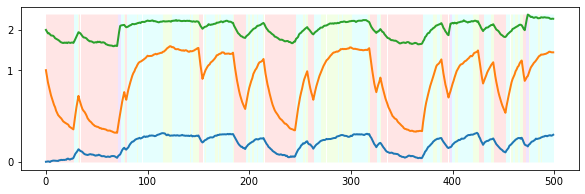

In [34]:
# Generate samples from AR-HMM (can replace this with HMM)
shape = [500, # number of time points
         1, # number of trials
         3] # number of dimensions

X, Y, probs_x, probs_y = ARHMM(shape=shape, K=K)
V.plot_signals(Y[:,0,:].cpu(),z=X.cpu().squeeze())

In [35]:
print(X.shape)
print(Y.shape)

torch.Size([500])
torch.Size([500, 1, 3])


In [38]:
# Setting random seed and clearing the cache
pyro.set_rng_seed(seed)
pyro.clear_param_store()

# Variational family is Delta, so we are doing MAP inference
guide = AutoDelta(poutine.block(ARHMM, expose_fn=lambda msg: msg["name"].startswith("probs_")))

# We choose Adam optimizer
optim = Adam({"lr": 1.0})

# Probabilistic cost is chosen to be Evidence Lower Bound (ELBO) 
elbo = TraceTMC_ELBO(max_plate_nesting=2)

# Telling the inference module to marginalize discrete variables in parallel
tmc_model = poutine.infer_config(ARHMM,
    lambda msg: {"num_samples": tmc_num_samples, "expand": False} if msg["infer"].get("enumerate", None) == "parallel" else {},
)

# Creating an instance of stochastic variational inference class (SVI)
svi = SVI(tmc_model, guide, optim, elbo)

losses = []

# Running variational inference
for step in range(num_steps):
    loss = svi.step(data=Y, K=K, batch_size=1)
    losses.append(loss)
    logging.info("{: >5d}\t{}".format(step, loss))


   748679     0	27006.212890625
   751445     1	21476.71875
   754062     2	17288.919921875
   756909     3	14085.4140625
   760576     4	12047.4833984375
   764105     5	10150.546875
   766885     6	9397.453125
   769844     7	8408.916015625
   772627     8	7314.58056640625
   775305     9	6217.3603515625


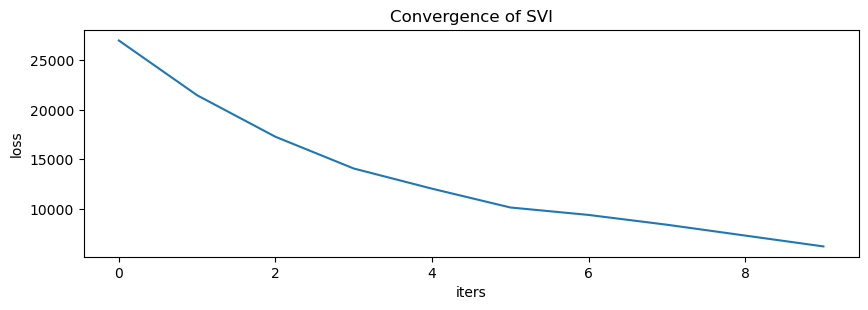

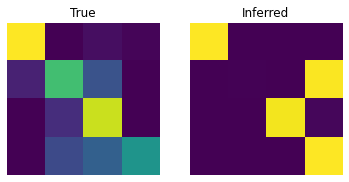

True centers
[[  0.9939693  -17.008026    -3.8006663 ]
 [  6.533641     4.506347     1.759718  ]
 [  6.861352     2.9375095    1.7705275 ]
 [  4.3923287   -0.15037486  13.085453  ]]

Inferred centers


array([[  1.0249788, -13.091955 ,  -4.002687 ],
       [  8.001615 ,   5.8668184,   1.7455175],
       [  6.078247 ,   2.7621093,  11.040211 ],
       [  8.418378 ,   5.193971 ,   1.9622865]], dtype=float32)

In [39]:
# Inspecting inferred model parameters
# Notice that inferred states and centers should match the true ones up to a permutation
map_estimates = guide(Y)

V.plot_loss(losses)

# Comparing inferred transition matrix with the true one
V.plot_transition([probs_x.detach().numpy(),map_estimates['probs_x'].detach().numpy()],titles=['True','Inferred'])

# Comparing state centers with the true ones
print('True centers')
print(probs_y.detach().numpy())
print('')

print('Inferred centers')
map_estimates['probs_y'].detach().numpy()